## Loading packages

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

In [3]:
import session_info
session_info.show()

In [4]:
results_folder = '/nfs/team205/heart/cell2location/foetal'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures/ver28Feb2023'
run_name = f'{results_folder}/cell2location_map/ver28Feb2023'

## Data, parameters

In [5]:
scRNA_path='/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw.h5ad'
celltype_key='fine_grain'

## Loading scRNA-seq reference data

In [6]:
# Read scRNA data
adata = sc.read(scRNA_path)
adata

AnnData object with n_obs × n_vars = 297473 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score'
    var: 'gene_name_scRNA-0', 'gene_id'
    uns: 'FACSgate_colors', '_scvi_manager_uuid', '_scvi_uuid', 'age_colors', 'cell_or_nucl

In [7]:
adata.X.data[:10]

array([ 1.,  1.,  5.,  5.,  8.,  4., 13.,  4.,  3.,  1.], dtype=float32)

In [8]:
set(adata.obs[celltype_key])

{'AtrialCardiomyocytesCycling',
 'AtrialCardiomyocytesLeft',
 'AtrialCardiomyocytesRight',
 'AtrioventricularNodeCardiomyocytes',
 'BCells',
 'BCellsMS4A1pos',
 'ChromaffinCells',
 'CoronaryArterialEndothelialCells',
 'CoronaryCapillaryEndothelialCells',
 'CoronaryPericytes',
 'CoronarySmoothMuscleCells',
 'CoronaryVenousEndothelialCells',
 'CoronaryVesselAdventitialFibroblasts',
 'DendriticCellsMature',
 'DendriticCellsType1',
 'DuctusArteriosusSmoothMuscleCells',
 'EndocardialCells',
 'EndocardialCushionCells',
 'EpicardiumDerivedCells',
 'GreatVesselAdventitialFibroblasts',
 'GreatVesselArterialEndothelialCells',
 'GreatVesselSmoothMuscleCells',
 'GreatVesselVenousEndothelialCells',
 'InnateLymphoidCells',
 'LymphNodeFibroblasticReticularCells',
 'LymphaticEndothelialCells',
 'MacrophagesATF3pos',
 'MacrophagesCX3CR1pos',
 'MacrophagesLYVE1pos',
 'MacrophagesTIMD4pos',
 'MastCells',
 'Megakaryocytes',
 'MesothelialEpicardialCells',
 'MonocyteDerivedCells',
 'Monocytes',
 'MonocytesM

In [9]:
# Make sure .var_names are ENSEMBL IDs
adata.var.head()

,gene_name_scRNA-0,gene_id
gene_name_multiome-1,,
MIR1302-2HG,MIR1302-2HG,ENSG00000243485
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092
AL627309.1,AL627309.1,ENSG00000238009
AL627309.3,AL627309.3,ENSG00000239945


In [10]:
adata.obs['batch_key'].value_counts()

Hst41_Nuclei_Multiome-v1    104878
Hst33_Nuclei_Multiome-v1     38234
Hst39_Nuclei_Multiome-v1     25386
C99_Cell_5prime-v2           17547
C92_Nuclei_Multiome-v1       13770
C94_Cell_5prime-v2           12985
Hst40_Nuclei_Multiome-v1      9708
C97_Cell_5prime-v2            9702
BRC2251_Cell_3prime-v3        9121
BRC2256_Cell_3prime-v3        7948
Hst36_Nuclei_Multiome-v1      7268
BRC2252_Cell_3prime-v3        6854
C86_Cell_5prime-v2            6376
BRC2260_Cell_3prime-v3        6004
BRC2263_Cell_3prime-v3        5662
BRC2262_Cell_3prime-v3        4129
C87_Nuclei_Multiome-v1        3907
C98_Nuclei_Multiome-v1        2660
C104_Nuclei_Multiome-v1       2490
C85_Nuclei_Multiome-v1        2436
C82_Nuclei_Multiome-v1         408
Name: batch_key, dtype: int64

In [11]:
set(adata.obs['batch_key'])

{'BRC2251_Cell_3prime-v3',
 'BRC2252_Cell_3prime-v3',
 'BRC2256_Cell_3prime-v3',
 'BRC2260_Cell_3prime-v3',
 'BRC2262_Cell_3prime-v3',
 'BRC2263_Cell_3prime-v3',
 'C104_Nuclei_Multiome-v1',
 'C82_Nuclei_Multiome-v1',
 'C85_Nuclei_Multiome-v1',
 'C86_Cell_5prime-v2',
 'C87_Nuclei_Multiome-v1',
 'C92_Nuclei_Multiome-v1',
 'C94_Cell_5prime-v2',
 'C97_Cell_5prime-v2',
 'C98_Nuclei_Multiome-v1',
 'C99_Cell_5prime-v2',
 'Hst33_Nuclei_Multiome-v1',
 'Hst36_Nuclei_Multiome-v1',
 'Hst39_Nuclei_Multiome-v1',
 'Hst40_Nuclei_Multiome-v1',
 'Hst41_Nuclei_Multiome-v1'}

## Remove cells

* Cycling cells
* Pericardial cells

In [12]:
# remove pericardial cells
adata = adata[adata.obs['fine_grain'].isin(['PericardialCells1','PericardialCells2','PericardialCells3'])==False]

# remove cycling cells
adata = adata[adata.obs['cycling']=='no']

adata.shape

(186909, 36601)

## <del>Add Atria Ventricle key

In [ ]:
'''
atrial_or_ventricular = {
    # 'AtrialCardiomyocytesCycling':'atrial',
 'AtrialCardiomyocytesLeft':'atrial',
 'AtrialCardiomyocytesRight':'atrial',
 'AtrioventricularNodeCardiomyocytes':'either',
 'BCells':'either',
 'BCellsMS4A1pos':'either',
 'ChromaffinCells':'either',
 'CoronaryArterialEndothelialCells':'either',
 'CoronaryCapillaryEndothelialCells':'either',
 'CoronaryPericytes':'either',
 'CoronarySmoothMuscleCells':'either',
 'CoronaryVenousEndothelialCells':'either',
 'CoronaryVesselAdventitialFibroblasts':'either',
 'DendriticCellsMature':'either',
 'DendriticCellsType1':'either',
 'DuctusArteriosusSmoothMuscleCells':'atrial',
 'EndocardialCells':'either',
 'EndocardialCushionCells':'either',
 'EpicardiumDerivedCells':'either',
 'GreatVesselAdventitialFibroblasts':'atrial',
 'GreatVesselArterialEndothelialCells':'atrial',
 'GreatVesselSmoothMuscleCells':'atrial',
 'GreatVesselVenousEndothelialCells':'atrial',
 'InnateLymphoidCells':'either',
 'LymphNodeFibroblasticReticularCells':'either',
 'LymphaticEndothelialCells':'either',
 'MacrophagesATF3pos':'either',
 'MacrophagesCX3CR1pos':'either',
 'MacrophagesLYVE1pos':'either',
 'MacrophagesTIMD4pos':'either',
 'MastCells':'either',
 'Megakaryocytes':'either',
 'MesothelialEpicardialCells':'either',
 'MonocyteDerivedCells':'either',
 'Monocytes':'either',
 'MonocytesMPOpos':'either',
 'MyocardialInterstitialFibroblasts1':'either',
 'MyocardialInterstitialFibroblasts2':'either',
 'Myofibroblasts':'either',
 'NaturalKillerCells':'either',
 'NeuronPrecursors':'either',
 'ParaympatheticNeurons':'either',
 # 'PericardialCells1':'either',
 # 'PericardialCells2':'either',
 # 'PericardialCells3':'either',
 'PlasmacytoidDendriticCells':'either',
 'ProBCells':'either',
 'SchwannCellPrecursors':'either',
 'SchwannCells':'either',
 'SinoatrialNodeCardiomyocytes':'atrial',
 'SympatheticNeurons':'either',
 'TCellsCD4pos':'either',
 'TCellsCD8pos':'either',
 'TregsCD4pos':'either',
 'ValveEndothelialCells':'either',
 'ValveInterstitialCells':'either',
 # 'VentricularCardiomyocytesCycling':'ventricular',
 'VentricularCardiomyocytesLeftCompact':'ventricular',
 'VentricularCardiomyocytesLeftTrabeculated':'ventricular',
 'VentricularCardiomyocytesRightCompact':'ventricular',
 'VentricularCardiomyocytesRightTrabeculated':'ventricular',
 'VentricularConductionSystemDistal':'ventricular',
 'VentricularConductionSystemProximal':'ventricular'}

if set(adata.obs['fine_grain']) == set(atrial_or_ventricular.keys()):
    adata.obs['atrialorventricular']=adata.obs['fine_grain'].astype('str').copy()
    adata.obs.replace({'atrialorventricular':atrial_or_ventricular},inplace=True)
else:
    print('ERROR: the cell type names are not matching')

pd.set_option("max_rows", 100)
pd.crosstab(adata.obs['fine_grain'],adata.obs['atrialorventricular'])
'''

## Estimation of reference cell type signatures (NB regression)

In [14]:
regions = ['whole_woPeriCell'] #,'atrial','ventricular'

##### whole_woPeriCell #####


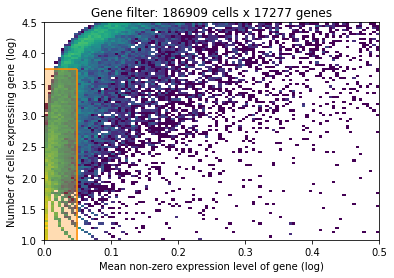

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["fine_grain"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 186909 cells, 17277 vars, 21      
         batches, 58 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 186909 │
│             Vars             │ 17277  │
│            Labels            │   58   │
│           Batches            │   21   │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   0    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                                      Label Categories                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃                 Categories                 ┃ scvi-tools Encodin ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['fine_grain'] │          AtrialCardiomyocytesLeft          │         0          │
│                         │         AtrialCardiomyocytesRight          │         1          │
│                         │    VentricularCardiomyocytesLeftCompact    │         2          │
│                         │   VentricularCardiomyocytesRightCompact    │         3          │
│                         │ VentricularCardiomyocytesLeftTrabeculated  │         4          │
│                         │ VentricularCardiomyocytesRightTrabeculated │         5          │
│                         │        SinoatrialNodeCardiomyocytes        │         6          │
│                         │     AtrioventricularNodeCardiomyocytes     │         7          │
│                         │    VentricularConductionSystemProximal     │         8          │
│                         │     VentricularConductionSystemDistal      │         9          │
│                         │     GreatVesselAdventitialFibroblasts      │         10         │
│                         │    CoronaryVesselAdventitialFibroblasts    │         11         │
│                         │     MyocardialInterstitialFibroblasts1     │         12         │
│                         │     MyocardialInterstitialFibroblasts2     │         13         │
│                         │               Myofibroblasts               │         14         │
│                         │    LymphNodeFibroblasticReticularCells     │         15         │
│                         │           ValveInterstitialCells           │         16         │
│                         │        GreatVesselSmoothMuscleCells        │         17         │
│                         │         CoronarySmoothMuscleCells          │         18         │
│                         │     DuctusArteriosusSmoothMuscleCells      │         19         │
│                         │             CoronaryPericytes              │         20         │
│                         │    GreatVesselArterialEndothelialCells     │         21         │
│                         │     GreatVesselVenousEndothelialCells      │         22         │
│                         │      CoronaryArterialEndothelialCells      │         23         │
│                         │       CoronaryVenousEndothelialCells       │         24         │
│                         │     CoronaryCapillaryEndothelialCells      │         25         │
│                         │              EndocardialCells              │         26         │
│                         │          EndocardialCushionCells           │         27         │
│                         │           ValveEndothelialCells            │         28         │
│                         │         LymphaticEndothelialCells          │         29         │
│                         │         MesothelialEpicardialCells         │         30         │
│                         │           EpicardiumDerivedCells           │         31         │
│                         │              NeuronPrecursors              │         32         │
│                         │              ChromaffinCells               │         33         │
│                         │             SympatheticNeurons             │         34         │
│                         │           ParaympatheticNeurons            │         35         │
│                         │           SchwannCellPrecursors            │         36         │
│                         │                SchwannCells                │         37         │
│                         │              MonocytesMP

                             Batch Categories                              
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  BRC2251_Cell_3prime-v3  │          0          │
│                        │  BRC2252_Cell_3prime-v3  │          1          │
│                        │  BRC2256_Cell_3prime-v3  │          2          │
│                        │  BRC2260_Cell_3prime-v3  │          3          │
│                        │  BRC2262_Cell_3prime-v3  │          4          │
│                        │  BRC2263_Cell_3prime-v3  │          5          │
│                        │  C82_Nuclei_Multiome-v1  │          6          │
│                        │  C85_Nuclei_Multiome-v1  │          7          │
│                        │    C86_Cell_5prime-v2    │          8          │
│                        │  C87_Nuclei_Multiome-v1  │          9          │
│                        │  C92_Nuclei_Multiome-v1  │         10          │
│                        │    C94_Cell_5prime-v2    │         11          │
│                        │    C97_Cell_5prime-v2    │         12          │
│                        │  C98_Nuclei_Multiome-v1  │         13          │
│                        │    C99_Cell_5prime-v2    │         14          │
│                        │ C104_Nuclei_Multiome-v1  │         15          │
│                        │ Hst33_Nuclei_Multiome-v1 │         16          │
│                        │ Hst36_Nuclei_Multiome-v1 │         17          │
│                        │ Hst39_Nuclei_Multiome-v1 │         18          │
│                        │ Hst40_Nuclei_Multiome-v1 │         19          │
│                        │ Hst41_Nuclei_Multiome-v1 │         20          │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:17<00:00, 58.03it/s]


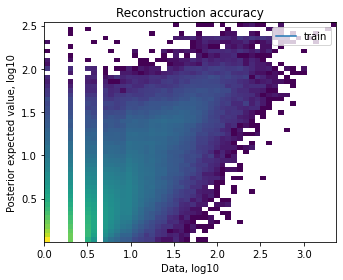

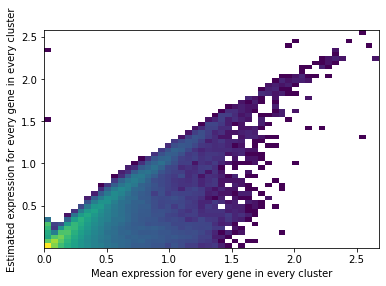

CPU times: user 4h 39min, sys: 2h 58min 41s, total: 7h 37min 42s
Wall time: 6h 13min 10s


In [15]:
%%time

from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

for reg in regions:
    print(f'##### {reg} #####')
    
    '''
    # subset adata
    if reg == 'whole_woPeriCell':
        adata_ref = adata.copy()
    else:
        adata_ref = adata[adata.obs['atrialorventricular'].isin(['either',reg])]
    '''
    
    adata_ref = adata.copy()
    
    # show cell types
    adata_ref.obs['fine_grain'].value_counts()
    
    # before we estimate the reference cell type signature we recommend to perform very permissive genes selection
    # in this 2D histogram orange rectangle lays over excluded genes.
    # In this case, the downloaded dataset was already filtered using this method,
    # hence no density under the orange rectangle
    selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    # filter the object
    adata_ref = adata_ref[:, selected].copy()

    # remove cell_states, which have only 2 cells or less
    counts = adata_ref.obs[celltype_key].value_counts()
    adata_ref = adata_ref[adata_ref.obs[celltype_key].isin(list(counts.keys()[counts>2]))]

    # prepare anndata for the regression model
    adata_ref=adata_ref.copy()
    scvi.data.setup_anndata(adata=adata_ref, 
                            # 10X reaction / sample / batch
                            batch_key='batch_key', 
                            # cell type, covariate used for constructing signatures
                            labels_key=celltype_key, 
                            # multiplicative technical effects (platform, 3' vs 5', donor effect)
                            # categorical_covariate_keys=['Method']
                           )
    scvi.data.view_anndata_setup(adata_ref)

    # create and train the regression model
    mod = RegressionModel(adata_ref) 

    # Use all data for training (validation not implemented yet, train_size=1)
    mod.train(max_epochs=1000, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

    # plot ELBO loss history during training, removing first 20 epochs from the plot
    mod.plot_history(20)

    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_ref = mod.export_posterior(
        adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{ref_run_name}/{reg}/", overwrite=True)

    # Save anndata object with results
    # adata_file = f"{ref_run_name}/{reg}/sc.h5ad"
    adata_ref.write(f"{ref_run_name}/{reg}/sc.h5ad")

    mod.plot_QC()

    # export estimated expression in each cluster
    if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
        inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_ref.uns['mod']['factor_names']]].copy()
    else:
        inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_ref.uns['mod']['factor_names']]].copy()
    inf_aver.columns = adata_ref.uns['mod']['factor_names']
    inf_aver.iloc[0:5, 0:5]

    # save inf_aver
    inf_aver.to_csv(f"{ref_run_name}/{reg}/inf_aver.csv")
    
    del adata_ref,mod,inf_aver,selected,counts

In [17]:
pd.read_csv(f"{ref_run_name}/{reg}/inf_aver.csv", index_col=0)

,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,VentricularCardiomyocytesLeftCompact,VentricularCardiomyocytesRightCompact,VentricularCardiomyocytesLeftTrabeculated,VentricularCardiomyocytesRightTrabeculated,SinoatrialNodeCardiomyocytes,AtrioventricularNodeCardiomyocytes,VentricularConductionSystemProximal,VentricularConductionSystemDistal,...,MastCells,Megakaryocytes,TCellsCD4pos,TCellsCD8pos,TregsCD4pos,ProBCells,BCells,BCellsMS4A1pos,NaturalKillerCells,InnateLymphoidCells
gene_name_multiome-1,,,,,,,,,,,,,,,,,,,,,
LINC01409,0.032476,0.046158,0.021414,0.014165,0.019709,0.014571,0.055468,0.088265,0.027819,0.026400,...,0.085503,0.031698,0.051254,0.066745,0.040194,0.010102,0.007922,0.041052,0.042153,0.072067
LINC01128,0.468364,0.610230,0.533129,0.475050,0.523244,0.518382,0.239848,0.369789,0.279122,0.272789,...,0.155507,0.071585,0.161296,0.099748,0.076072,0.014329,0.049095,0.039478,0.037442,0.197922
SAMD11,0.001929,0.006399,0.000448,0.000553,0.001442,0.002508,0.166481,0.049362,0.009585,0.001881,...,0.006315,0.008826,0.010507,0.000681,0.000849,0.003511,0.002614,0.005824,0.000758,0.017903
NOC2L,0.082863,0.113198,0.078209,0.087036,0.073827,0.083329,0.092166,0.108923,0.091744,0.062285,...,0.075813,0.059751,0.115856,0.122003,0.101545,0.028810,0.040647,0.072550,0.063325,0.098321
HES4,0.072260,0.111780,0.055069,0.104354,0.046015,0.089226,0.102774,0.119472,0.068789,0.050086,...,0.013178,0.019631,0.012555,0.000766,0.001309,0.004969,0.001057,0.004613,0.000797,0.002878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-CYB,6.842916,10.593540,4.722632,5.571266,5.092852,5.744652,6.613464,9.851303,5.009043,3.584691,...,0.288037,1.493395,2.533678,1.866008,2.807834,0.045747,0.035797,1.669786,1.016820,1.918102
AC011043.1,0.066433,0.103032,0.038362,0.044075,0.055222,0.049679,0.104354,0.114325,0.047517,0.039529,...,0.061442,0.029552,0.013959,0.009446,0.028855,0.009475,0.002494,0.006601,0.019837,0.030013
AL592183.1,0.056256,0.087727,0.000700,0.001555,0.030053,0.017050,0.075170,0.036125,0.012883,0.035017,...,0.018539,0.008577,0.082689,0.059149,0.052302,0.010879,0.005178,0.035016,0.017875,0.019762
